In [2]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# VEST SC 2016

Note: This notebook performs only election data validation

In [3]:
STATE_NAME = 'SC'
STATE_YEAR = '2016'

#### Functions used

1. allocating votes

In [4]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

2. precinct level validation

In [70]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

3. state level validation

In [6]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

4. county level validation

In [7]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

## VEST's Documentation File

### Sources

Election results from South Carolina State Election Commission (http://www.enr-scvotes.org/SC/64658/184701/en/select-county.html)


Precinct shapefiles were generously supplied by Victor Frontroth of the Mapping Section of the South Carolina Revenue and Fiscal Affairs Office



### Processing

Election data processing:
  - Absentee, provisional, emergency, and failsafe results were reported countywide. These were distributed to precincts based on the precinct's share of the county vote for each candidate.

### Candidates

Presidential
- G16PREDCLI - Hillary Clinton (Democratic Party)
- G16PRERTRU - Donald Trump (Republican Party)
- G16PRELJOH - Gary Johnson (Libertarian Party)
- G16PREGSTE - Jill Stein (Green Party)
- G16PREIMCM - Evan McMullin (Independent)
- G16PRECCAS - Darrell L. Castle (Constitution Party)
- G16PREASKE - Peter Skewes (American Party)

U.S. Senate
- G16USSDDIX - Thomas Dixon (Democratic Party, Working Families Party, and Green Party (fusion candidate))
- G16USSRSCO - Tim Scott (Republican Party)
- G16USSLBLE - Bill Bledsoe (Libertarian Party and Constitution Party (fusion candidate))
- G16USSASCA - Rebel Michael Scarborough (American Party)
- G16USSOWRI - Write-in Votes

In [8]:
races = [
    #President
    'G16PREDCLI',
    'G16PRERTRU',
    'G16PRELJOH',
    'G16PREGSTE',
    'G16PREIMCM',
    'G16PRECCAS',
    'G16PREASKE',
    
    #U.S. Senate
    'G16USSDDIX',
    'G16USSRSCO',
    'G16USSLBLE',
    'G16USSASCA',
    'G16USSOWRI'
    
]

### Load in VEST file

In [9]:
state_name_year = STATE_NAME + '_' + STATE_YEAR
path_to_vest_file = 'raw-from-source/VEST/' + state_name_year + '/' + state_name_year + '.shp'
vest = gp.read_file(path_to_vest_file)

In [10]:
vest.crs

<Projected CRS: EPSG:2273>
Name: NAD83 / South Carolina (ft)
Axis Info [cartesian]:
- X[east]: Easting (foot)
- Y[north]: Northing (foot)
Area of Use:
- name: United States (USA) - South Carolina - counties of Abbeville; Aiken; Allendale; Anderson; Bamberg; Barnwell; Beaufort; Berkeley; Calhoun; Charleston; Cherokee; Chester; Chesterfield; Clarendon; Colleton; Darlington; Dillon; Dorchester; Edgefield; Fairfield; Florence; Georgetown; Greenville; Greenwood; Hampton; Horry; Jasper; Kershaw; Lancaster; Laurens; Lee; Lexington; Marion; Marlboro; McCormick; Newberry; Oconee; Orangeburg; Pickens; Richland; Saluda; Spartanburg; Sumter; Union; Williamsburg; York.
- bounds: (-83.36, 32.05, -78.52, 35.21)
Coordinate Operation:
- name: SPCS83 South Carolina zone (International feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

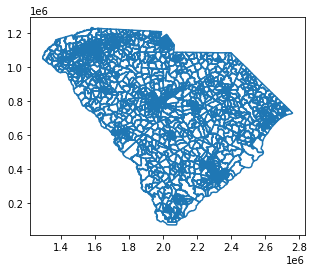

In [11]:
vest.boundary.plot()

In [12]:
vest.columns

Index(['PNAME', 'COUNTY', 'G16PREDCLI', 'G16PRERTRU', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREIMCM', 'G16PRECCAS', 'G16PREASKE', 'G16USSDDIX',
       'G16USSRSCO', 'G16USSLBLE', 'G16USSASCA', 'G16USSOWRI', 'geometry'],
      dtype='object')

In [13]:
vest.head(5)

,PNAME,COUNTY,G16PREDCLI,G16PRERTRU,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PREASKE,G16USSDDIX,G16USSRSCO,G16USSLBLE,G16USSASCA,G16USSOWRI,geometry
0,Aiken No. 1,003,218,507,35,13,18,1,1,177,579,17,3,0,"POLYGON Z ((1780603.935 628560.290 0.000, 1780..."
1,Aiken No. 2,003,535,157,13,5,2,2,0,504,172,9,8,1,"POLYGON Z ((1775948.018 634542.032 0.000, 1776..."
2,Aiken No. 3,003,745,136,12,5,7,2,1,714,143,18,8,1,"POLYGON Z ((1788795.417 636793.331 0.000, 1788..."
3,Aiken No. 4,003,339,46,4,5,2,1,0,321,61,3,1,0,"POLYGON Z ((1787324.836 631829.353 0.000, 1787..."
4,Aiken No. 5,003,365,276,15,9,5,1,7,329,320,14,1,0,"POLYGON Z ((1790601.222 622506.538 0.000, 1790..."


In [14]:
vest.shape

(2235, 15)

Check to see if PNAME is a unique field

In [15]:
print(len(vest['PNAME']) == len(vest['PNAME'].unique()))

False


Check to see if combination of County and PNAME fields is a unique id

In [16]:
vest['uniqueid'] = vest['COUNTY'] + vest['PNAME']
print(len(vest['uniqueid']) == len(vest['uniqueid'].unique()))

False


In [17]:
print("len of county+PNAME:", len(vest['uniqueid'].unique()))
print("len of precincts:", len(vest))

len of county+PNAME: 2234
len of precincts: 2235


Find the repeat County + PNAME combo

In [18]:
vest['uniqueid'].value_counts()


059LAURENS 6             2
035OAKBROOK 2            1
061MANVILLE              1
079EASTOVER              1
083ARCADIA ELEMENTARY    1
                        ..
047BRADLEY               1
091PALMETTO              1
015MCBETH                1
077NORRIS                1
083TRINITY METHODIST     1
Name: uniqueid, Length: 2234, dtype: int64

LAURENS6 in county 059 is the repeat uniqueid

## Election Results

### Load, Clean, Pivot Election Results

Select the election results directory

In [19]:
file_list = os.listdir("./raw-from-source/Election_Results/2016 County Detail Spreadsheets")


Modify the loaded in csv to select necessary data for the presidential race

In [20]:
li = []
for county in file_list:
    if county.endswith('.csv') and not county.endswith('Senate.csv'):
        file_ref = "./raw-from-source/Election_Results/2016 County Detail Spreadsheets/"+county
        file_prev = pd.read_csv(file_ref)
        file_prev.columns = file_prev.iloc[0]
        file_prev = file_prev[2:]

        file_prev.columns.values[0] = 'Precinct'
        file_prev = file_prev.reset_index().drop(columns=['index'])
        file_prev = file_prev.loc[:, file_prev.columns.notnull()]
        file_prev['County'] = county[:-4]
        li.append(file_prev)
        
president_raw_df = pd.concat(li, axis=0, ignore_index=True)
display(president_raw_df)

,Precinct,Hillary Rodham Clinton / Timothy Michael Kaine,Darrell Castle / Scott Bradley,Evan McMullin / Nathan Johnson,Jill Stein / Ajamu Baraka,Donald J Trump / Michael R Pence,Peter Skewes / Michael Lacy,Gary Johnson / Bill Weld,County
0,ADAMSBURG,69,0,3,1,338,1,6,Union
1,BLACK ROCK,145,1,1,0,97,1,2,Union
2,BONHAM,165,1,4,1,331,0,9,Union
3,BUFFALO BOX 1,111,2,6,5,382,1,4,Union
4,CARLISLE,270,1,0,2,31,0,2,Union
...,...,...,...,...,...,...,...,...,...
2591,Emergency,0,0,0,0,0,0,0,Lexington
2592,Failsafe,70,0,2,1,124,0,4,Lexington
2593,Provisional,43,0,1,2,77,0,6,Lexington
2594,Failsafe Provisional,43,0,2,1,78,0,4,Lexington


Modify a different set of .csvs to select necessary data for the senate race

In [21]:
li = []
for county in file_list:
    if county.endswith('Senate.csv'):
        file_ref = "./raw-from-source/Election_Results/2016 County Detail Spreadsheets/"+county
        file_prev = pd.read_csv(file_ref)
        file_prev.columns = file_prev.iloc[0]
        file_prev = file_prev[2:]

        file_prev.columns.values[0] = 'Precinct'
        file_prev = file_prev.reset_index().drop(columns=['index'])
        file_prev = file_prev.loc[:, file_prev.columns.notnull()]
        file_prev['County'] = county.split('_')[0]
        file_prev.rename(columns = {'WRITE-IN': 'Write-In'}, inplace=True)
        file_prev = file_prev.astype({
            'Bill Bledsoe': int,
            'Rebel Michael Scarborough': int,
            'Thomas Dixon': int,
            'Tim Scott': int,
            'Write-In': int
        })
        file_prev = file_prev.groupby(level=0, axis=1).sum()
        li.append(file_prev)
        
senate_raw_df = pd.concat(li, axis=0, ignore_index=True)
display(senate_raw_df)

,Bill Bledsoe,County,Precinct,Rebel Michael Scarborough,Thomas Dixon,Tim Scott,Write-In
0,1,Williamsburg,BLACK RIVER,4,86,84,0
1,2,Williamsburg,BLOOMINGVALE,4,308,178,0
2,4,Williamsburg,CADES,0,151,104,0
3,1,Williamsburg,CEDAR SWAMP,0,72,100,1
4,2,Williamsburg,CENTRAL,1,277,188,0
...,...,...,...,...,...,...,...
2591,2,York,Provisional 2,1,35,38,0
2592,0,York,Provisional 3,1,22,32,0
2593,0,York,Provisional 4,2,2,16,0
2594,19,York,Failsafe Prov 1,4,225,311,1


In [22]:
# Create a unique id for both by combining county + precinct
president_raw_df['County_Precinct'] = president_raw_df['County'] + '-' + president_raw_df['Precinct']
senate_raw_df['County_Precinct'] = senate_raw_df['County'] + '-' + senate_raw_df['Precinct']

# Merge both dfs
pres_senate_merge = pd.merge(president_raw_df, senate_raw_df, how="outer", on="County_Precinct", indicator=True)
assert(pres_senate_merge["_merge"].value_counts().both == len(president_raw_df))

display(pres_senate_merge)

,Precinct_x,Hillary Rodham Clinton / Timothy Michael Kaine,Darrell Castle / Scott Bradley,Evan McMullin / Nathan Johnson,Jill Stein / Ajamu Baraka,Donald J Trump / Michael R Pence,Peter Skewes / Michael Lacy,Gary Johnson / Bill Weld,County_x,County_Precinct,Bill Bledsoe,County_y,Precinct_y,Rebel Michael Scarborough,Thomas Dixon,Tim Scott,Write-In,_merge
0,ADAMSBURG,69,0,3,1,338,1,6,Union,Union-ADAMSBURG,7,Union,ADAMSBURG,8,71,301,0,both
1,BLACK ROCK,145,1,1,0,97,1,2,Union,Union-BLACK ROCK,3,Union,BLACK ROCK,1,141,97,0,both
2,BONHAM,165,1,4,1,331,0,9,Union,Union-BONHAM,7,Union,BONHAM,3,145,333,0,both
3,BUFFALO BOX 1,111,2,6,5,382,1,4,Union,Union-BUFFALO BOX 1,15,Union,BUFFALO BOX 1,5,110,354,1,both
4,CARLISLE,270,1,0,2,31,0,2,Union,Union-CARLISLE,3,Union,CARLISLE,1,238,45,0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,Emergency,0,0,0,0,0,0,0,Lexington,Lexington-Emergency,0,Lexington,Emergency,0,0,0,0,both
2592,Failsafe,70,0,2,1,124,0,4,Lexington,Lexington-Failsafe,4,Lexington,Failsafe,1,64,125,1,both
2593,Provisional,43,0,1,2,77,0,6,Lexington,Lexington-Provisional,6,Lexington,Provisional,1,32,83,0,both
2594,Failsafe Provisional,43,0,2,1,78,0,4,Lexington,Lexington-Failsafe Provisional,4,Lexington,Failsafe Provisional,1,37,83,0,both


Rename the resulting raw df 

In [23]:
# select necessary columns
county_df = pres_senate_merge[[
    'County_Precinct',
    'Hillary Rodham Clinton / Timothy Michael Kaine',
    'Darrell Castle / Scott Bradley',
    'Evan McMullin / Nathan Johnson',
    'Jill Stein / Ajamu Baraka',
    'Donald J Trump / Michael R Pence',
    'Peter Skewes / Michael Lacy',
    'Gary Johnson / Bill Weld',
    'Bill Bledsoe',
    'Rebel Michael Scarborough',
    'Thomas Dixon',
    'Tim Scott',
    'Write-In',
    'Precinct_x',
    'County_x'
]].rename({
    'Hillary Rodham Clinton / Timothy Michael Kaine': 'G16PREDCLI',
    'Darrell Castle / Scott Bradley': 'G16PRECCAS',
    'Evan McMullin / Nathan Johnson': 'G16PREIMCM',
    'Jill Stein / Ajamu Baraka': 'G16PREGSTE',
    'Donald J Trump / Michael R Pence': 'G16PRERTRU',
    'Peter Skewes / Michael Lacy': 'G16PREASKE',
    'Gary Johnson / Bill Weld': 'G16PRELJOH',
    
    'Bill Bledsoe': 'G16USSLBLE',
    'Rebel Michael Scarborough': 'G16USSASCA',
    'Thomas Dixon': 'G16USSDDIX',
    'Tim Scott': 'G16USSRSCO',
    'Write-In': 'G16USSOWRI',
    
    'Precinct_x': 'Precinct',
    'County_x': 'County'
}, axis = 1)

county_df

,County_Precinct,G16PREDCLI,G16PRECCAS,G16PREIMCM,G16PREGSTE,G16PRERTRU,G16PREASKE,G16PRELJOH,G16USSLBLE,G16USSASCA,G16USSDDIX,G16USSRSCO,G16USSOWRI,Precinct,County
0,Union-ADAMSBURG,69,0,3,1,338,1,6,7,8,71,301,0,ADAMSBURG,Union
1,Union-BLACK ROCK,145,1,1,0,97,1,2,3,1,141,97,0,BLACK ROCK,Union
2,Union-BONHAM,165,1,4,1,331,0,9,7,3,145,333,0,BONHAM,Union
3,Union-BUFFALO BOX 1,111,2,6,5,382,1,4,15,5,110,354,1,BUFFALO BOX 1,Union
4,Union-CARLISLE,270,1,0,2,31,0,2,3,1,238,45,0,CARLISLE,Union
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,Lexington-Emergency,0,0,0,0,0,0,0,0,0,0,0,0,Emergency,Lexington
2592,Lexington-Failsafe,70,0,2,1,124,0,4,4,1,64,125,1,Failsafe,Lexington
2593,Lexington-Provisional,43,0,1,2,77,0,6,6,1,32,83,0,Provisional,Lexington
2594,Lexington-Failsafe Provisional,43,0,2,1,78,0,4,4,1,37,83,0,Failsafe Provisional,Lexington


### Perform statewide/county-level election data validation

drop total votes

In [26]:
clean_df = county_df[county_df['Precinct']!='Total:']

cast all votes to int

In [27]:
for race in races:
    clean_df = clean_df.astype({race: int,})

#### run statewide validation code

In [28]:
statewide_totals_check(vest, clean_df, races)

***Statewide Totals Check***
G16PREDCLI is equal 	VEST / RDH: 855373
G16PRERTRU is equal 	VEST / RDH: 1155389
G16PRELJOH is equal 	VEST / RDH: 49204
G16PREGSTE is equal 	VEST / RDH: 13034
G16PREIMCM is equal 	VEST / RDH: 21016
G16PRECCAS is equal 	VEST / RDH: 5765
G16PREASKE is equal 	VEST / RDH: 3246
G16USSDDIX is equal 	VEST / RDH: 757022
G16USSRSCO is equal 	VEST / RDH: 1241609
G16USSLBLE is equal 	VEST / RDH: 37482
G16USSASCA is equal 	VEST / RDH: 11923
G16USSOWRI is equal 	VEST / RDH: 1857


create matching county column in vest/source

create a FIPS dict

In [36]:
#load in FIPS info
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="South Carolina"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_num_to_name_dict = dict(zip(fips_file["FIPS County"], fips_file["County Name"]))
fips_name_to_num_dict = dict(zip(fips_file["County Name"], fips_file["FIPS County"]))

apply FIPS dict to vest df

In [37]:
vest['County'] = vest['COUNTY'].map(fips_num_to_name_dict)

#### run countywide validation code

In [38]:
county_totals_check(vest,clean_df,races,'County',full_print=False)

***Countywide Totals Check***

G16PREDCLI is equal across all counties
G16PRERTRU is equal across all counties
G16PRELJOH is equal across all counties
G16PREGSTE is equal across all counties
G16PREIMCM is equal across all counties
G16PRECCAS is equal across all counties
G16PREASKE is equal across all counties
G16USSDDIX is equal across all counties
G16USSRSCO is equal across all counties
G16USSLBLE is equal across all counties
G16USSASCA is equal across all counties
G16USSOWRI is equal across all counties


### Distribute countywide votes

isolate countywide votes

In [39]:
alloc_keywords = 'Absentee', 'Emergency', 'Failsafe', 'Provisional', 'ABSENTEE', 'EMERGENCY', 'FAILSAFE', 'PROVISIONAL'
countywide = clean_df[clean_df.Precinct.str.contains("|".join(alloc_keywords))]
non_countywide = clean_df.drop(countywide.index)

Allocate countywide votes

In [40]:
source = allocate_absentee(non_countywide,countywide,races,'County')

In [41]:
source

,County_Precinct,G16PREDCLI,G16PRECCAS,G16PREIMCM,G16PREGSTE,G16PRERTRU,G16PREASKE,G16PRELJOH,G16USSLBLE,G16USSASCA,G16USSDDIX,G16USSRSCO,G16USSOWRI,Precinct,County
0,Union-ADAMSBURG,86.0,0.0,3.0,1.0,409.0,2.0,7.0,8.0,10.0,87.0,366.0,0.0,ADAMSBURG,Union
1,Union-BLACK ROCK,180.0,1.0,1.0,0.0,117.0,2.0,2.0,4.0,1.0,173.0,118.0,0.0,BLACK ROCK,Union
2,Union-BONHAM,205.0,1.0,5.0,1.0,401.0,0.0,11.0,8.0,4.0,178.0,405.0,0.0,BONHAM,Union
3,Union-BUFFALO BOX 1,138.0,2.0,7.0,6.0,463.0,1.0,5.0,18.0,6.0,135.0,430.0,1.0,BUFFALO BOX 1,Union
4,Union-CARLISLE,335.0,1.0,0.0,2.0,38.0,0.0,2.0,4.0,1.0,292.0,55.0,0.0,CARLISLE,Union
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,Lexington-Redbank South #2,292.0,6.0,13.0,15.0,764.0,1.0,34.0,29.0,12.0,268.0,799.0,0.0,Redbank South #2,Lexington
2586,Lexington-Carolina Springs,327.0,9.0,17.0,12.0,784.0,0.0,50.0,30.0,8.0,290.0,859.0,1.0,Carolina Springs,Lexington
2587,Lexington-Platt Springs 1,198.0,3.0,13.0,4.0,716.0,2.0,17.0,37.0,13.0,173.0,712.0,0.0,Platt Springs 1,Lexington
2588,Lexington-Platt Springs 2,650.0,2.0,16.0,9.0,917.0,0.0,60.0,35.0,14.0,591.0,974.0,1.0,Platt Springs 2,Lexington


### Merge Source and VEST df

create a uniqueid in both dataframes and convert to upper for easier merges

In [42]:
source['uniqueid'] = source['County'].map(fips_dict) + source['Precinct']
source['uniqueid'] = source['uniqueid'].str.upper()
vest['uniqueid'] = vest['uniqueid'].str.upper()

<ipython-input-42-c2ac82d17b45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['uniqueid'] = source['County'].map(fips_dict) + source['Precinct']
<ipython-input-42-c2ac82d17b45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['uniqueid'] = source['uniqueid'].str.upper()


remove duplicate uniqueid entry in vest file

In [57]:
# find all entries that occur more than once
vc = vest['uniqueid'].value_counts()
repeat = vc[vc>1].index[0]
repeat_df = vest[vest['uniqueid'] == repeat]

,PNAME,COUNTY,G16PREDCLI,G16PRERTRU,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PREASKE,G16USSDDIX,G16USSRSCO,G16USSLBLE,G16USSASCA,G16USSOWRI,geometry,uniqueid,County
490,LAURENS 6,059,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((1684060.397 973018.217 0.000, 1684...",059LAURENS 6,Laurens


since first entry has zero votes, we can safely remove it for election data validation

In [58]:
vest.drop(repeat_df.head(1).index, inplace=True)

perform the merge

In [62]:
join_attempt = pd.merge(vest,source,how="outer",on="uniqueid",indicator=True)
print(join_attempt["_merge"].value_counts())

both          2232
left_only        2
right_only       0
Name: _merge, dtype: int64


create name change dict for similar precinct names to improve matching

In [63]:
name_change_dict = {
  '013SAINT HELENA 1A': '013ST. HELENA 1A',
  '013SAINT HELENA 1B': '013ST. HELENA 1B',
  '013SAINT HELENA 1C': '013ST. HELENA 1C',
  '013SAINT HELENA 2A': '013ST. HELENA 2A',
  '013SAINT HELENA 2B': '013ST. HELENA 2B',
  '013SAINT HELENA 2C': '013ST. HELENA 2C',
  '027BARROWS MILL': '027BARROWS',
  '027BLOOMVILLE': '027BLOOMINGVILLE',
  '027SARDINA-GABLE': '027SARDINIA - GABLE',
  '027WILSON FORESTON': '027WILSON-FORESTON',
  '061SOUTH LYNCHBURG': '061S. LYNCHBURG',
  '063BARR ROAD #1': '063BARR ROAD 1',
  '063BARR ROAD #2': '063BARR ROAD 2',
  '063BEULAH CHURCH': '063BEULAH  CHURCH',
  '063CAYCE WARD 2-A': '063CAYCE 2A',
  '063CAYCE WARD NO.1': '063CAYCE NO. 1',
  '063CAYCE WARD NO.2': '063CAYCE NO. 2',
  '063CAYCE WARD NO.3': '063CAYCE NO. 3',
  '063CONGAREE #1': '063CONGAREE 1',
  '063CONGAREE #2': '063CONGAREE 2',
  '063EDMUND #1': '063EDMUND 1',
  '063EDMUND #2': '063EDMUND 2',
  '063GASTON #1': '063GASTON 1',
  '063GASTON #2': '063GASTON 2',
  '063LAKE MURRAY #1': '063LAKE MURRAY 1',
  '063LAKE MURRAY #2': '063LAKE MURRAY 2',
  '063LEAPHART ROAD': '063LEAPHART RD',
  '063LEXINGTON #3': '063LEXINGTON NO. 3',
  '063LEXINGTON #4': '063LEXINGTON NO. 4',
  '063MT HEBRON': '063MT. HEBRON',
  '063OLD BARNWELL RD': '063OLD BARNWELL ROAD',
  '063PARK ROAD #1': '063PARK ROAD 1',
  '063PARK ROAD #2': '063PARK ROAD 2',
  '063PELION #1': '063PELION 1',
  '063PELION #2': '063PELION 2',
  '063PILGRIM CHURCH': '063PILGRIM CHRUCH',
  '063PINERIDGE #1': '063PINE RIDGE 1',
  '063PINERIDGE #2': '063PINE RIDGE 2',
  '063RED BANK SOUTH #1': '063RED BANK SOUTH 1',
  '063REDBANK SOUTH #2': '063RED BANK SOUTH 2',
  '063SANDHILL': '063SAND HILL',
  '063ST DAVIDS': '063ST. DAVIDS',
  '063SWANSEA #1': '063SWANSEA 1',
  '063SWANSEA #2': '063SWANSEA 2',
  '063W COLUMBIA NO 1': '063WEST COLUMBIA NO. 1',
  '063W COLUMBIA NO 2': '063WEST COLUMBIA NO. 2',
  '063W COLUMBIA NO 3': '063WEST COLUMBIA NO. 3',
  '063W COLUMBIA NO 4': '063WEST COLUMBIA NO. 4',
  '077STONE CHURCH': '077SOUTH CHURCH'
}

apply name changes

In [64]:
source['uniqueid'] = source['uniqueid'].map(name_change_dict).fillna(source['uniqueid'])

<ipython-input-64-801638e1a8d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['uniqueid'] = source['uniqueid'].map(name_change_dict).fillna(source['uniqueid'])


perform second merge with new names

In [65]:
join_attempt_two = pd.merge(vest,source,how="outer",on="uniqueid",indicator=True)
print(join_attempt_two["_merge"].value_counts())
merged = join_attempt_two[join_attempt_two["_merge"]=="both"]
right_only = join_attempt_two[join_attempt_two["_merge"]=="right_only"]
left_only = join_attempt_two[join_attempt_two["_merge"]=="left_only"]

both          2232
left_only        2
right_only       0
Name: _merge, dtype: int64


check to see non-merged entries are zero votes

In [66]:
data_columns = races
empty_precincts = []
for index, row in left_only.iterrows():
    number_of_zero_races = 0
    for race in data_columns:
        if (row[race + '_x']==0):
            number_of_zero_races+= 1
    if(number_of_zero_races == len(data_columns)):
        empty_precincts.append(row["uniqueid"])
print(len(empty_precincts))
assert(len(empty_precincts) == len(left_only))

2


perform precinct level validation

In [71]:
precinct_votes_check(merged,races,False,'uniqueid',print_level=2)

G16PREDCLI ........................................................041COWARDS NO. 1 (S) ..158  (V)..182 (D):  -24
G16PRERTRU ........................................................041COWARDS NO. 1 (S) ..512  (V)..442 (D):   70
G16PRELJOH ........................................................041COWARDS NO. 1 (S) ....4  (V)....8 (D):   -4
G16PREIMCM ........................................................041COWARDS NO. 1 (S) ....4  (V)....0 (D):    4
G16PREASKE ........................................................041COWARDS NO. 1 (S) ....0  (V)....4 (D):   -4
G16USSDDIX ........................................................041COWARDS NO. 1 (S) ..159  (V)..179 (D):  -20
G16USSRSCO ........................................................041COWARDS NO. 1 (S) ..480  (V)..424 (D):   56
G16USSLBLE ........................................................041COWARDS NO. 1 (S) ...12  (V)....8 (D):    4
G16PREDCLI ........................................................041COWARDS NO. 2 (S) 

In [ ]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [ ]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

In [ ]:
loaded_counties = os.listdir("./raw-from-source/2016 County Detail Spreadsheets/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xls'):
        file_string = "./raw-from-source/Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_recount = pd.DataFrame(z,columns=dfcols)